# Music Generation with RNNs 

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

# Load dataset

In [2]:
songs = mdl.lab1.load_training_data()
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 816 songs in text

Example song: 
X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!


In [3]:
mdl.lab1.play_song(example_song)

Output hidden; open in https://colab.research.google.com to view.

In [4]:
songs_joined = "\n\n".join(songs) # join song list into one string
vocab = sorted(songs_joined)
print("There are", len(vocab), "unique characters in the dataset")

There are 200425 unique characters in the dataset


# Process the dataset for learning
Two maps are needed: from character to number; from number to character

In [5]:
char2idx = {u:i for i, u in enumerate(vocab)} #dict
idx2char = np.array(vocab)
# print(char2idx, idx2char)

In [6]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n': 9425,
  ' ' : 28079,
  '!' : 31744,
  '"' : 31752,
  '#' : 31753,
  "'" : 32054,
  '(' : 32311,
  ')' : 32312,
  ',' : 32876,
  '-' : 34545,
  '.' : 34586,
  '/' : 36695,
  '0' : 36932,
  '1' : 38624,
  '2' : 47838,
  '3' : 50578,
  '4' : 51248,
  '5' : 51550,
  '6' : 52105,
  '7' : 52377,
  ...
}


In [7]:
# convert songs string to a single vector
def vectorize_string(string):
    return np.array([char2idx[i] for i in string])
vectorized_songs = vectorize_string(songs_joined)

In [8]:
print('{} --- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"
print(vectorized_songs.shape)

'X:2\nT:An B' --- characters mapped to int ----> [114282  61308  47838   9425 113368  61308  74047 177741  28079  85361]
(200425,)


## Create training examples and targets
E.g. input -> "Hell", output -> "ello", original text -> "Hello"

In [9]:
def get_batch(vectorized_songs, seq_length, batch_size):
    n = vectorized_songs.shape[0] - 1
    idx = np.random.choice(n-seq_length, batch_size)

    input_batch = np.array([vectorized_songs[i: i+seq_length] for i in idx])
    output_batch = np.array([vectorized_songs[i+1: i+1+seq_length] for i in idx])
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    return x_batch, y_batch

test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
    not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
    not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
    print("======\n[FAIL] could not pass tests")
else:
    print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [10]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)
for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 164610 ('f')
  expected output: 171664 ('g')
Step   1
  input: 171664 ('g')
  expected output: 28079 (' ')
Step   2
  input: 28079 (' ')
  expected output: 121779 ('a')
Step   3
  input: 121779 ('a')
  expected output: 47838 ('2')
Step   4
  input: 47838 ('2')
  expected output: 122955 ('b')


## RNN model

In [11]:
def LSTM(rnn_units):
    return tf.keras.layers.LSTM(
        rnn_units,
        return_sequences = True,
        recurrent_initializer = 'glorot_uniform',
        recurrent_activation = 'sigmoid',
        stateful = True
    )

In [12]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
                                 tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
                                 LSTM(rnn_units),
                                 tf.keras.layers.Dense(vocab_size)
    ])
    return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           51308800  
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 200425)        205435625 
Total params: 261,991,401
Trainable params: 261,991,401
Non-trainable params: 0
_________________________________________________________________


In [14]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:     ", x.shape, " # (batch_size, sequence_length")
print("Output shape:    ", pred.shape, " # (batch_size, sequence_length, vocab_size)")

Input shape:      (32, 100)  # (batch_size, sequence_length
Output shape:     (32, 100, 200425)  # (batch_size, sequence_length, vocab_size)


In [15]:
sample_indices = tf.random.categorical(pred[0], num_samples=1)
sample_indices = tf.squeeze(sample_indices, axis=-1).numpy()
sample_indices

array([167067, 115599, 185344, 199913,  32362,  38986,  52929,  78517,
        70908, 100917,  18642, 159218,  53513,  86438, 141247, 147010,
       118080,  27598,  47788,  64970,  12171, 106182,  98066, 102806,
       171951, 170582,  34317, 150255, 131659,  44216, 195148, 183167,
        33701, 105121, 143667,  33379, 193913, 181560,   9622, 160603,
       111713, 162412,  77358,  55251,  28452, 175633, 103307, 151492,
        91770, 183933,  97773,  88312, 186820,   5664,  16007, 139916,
       109923,  47602, 108091, 137279, 106995,  79141,  83275,  95153,
       123159,  85022,   6167, 117737, 151336, 100623,  18611, 145676,
        54827, 165121,  43907,  28631,  19349, 154229, 103861, 157607,
        17780,  19131,   4446, 137801,  13516, 162627,  24508, 163704,
        37467,  17510, 159558,   6957, 135118,  58114, 143417, 198651,
        60893, 194156, 110093, 164382])

In [16]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Prediction: \n", repr("".join(idx2char[sample_indices])))

Input: 
 ' BGG:|!\nA|BABd g2bg|agef gedB|GABd g2bg|agef g2ga|!\nbgg2 agef|gage dBGE|DEGA Bdge|dBAc BGG:|!\n\nX:12\n'

Next Char Prediction: 
 'g]||,28BAG f8Ddea 2A GFGhg-ed2|u-Gd-|r fMfB:!lGeEyFD|\n dL2GdGBBFcB\naeG e:g2! eGf  \nd f f1 f\nd:d|:|Lf'


In [17]:
## Define the loss 

In [18]:
def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss

example_batch_loss = compute_loss(y, pred)
print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("Scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 200425)  # (batch_size, sequence_length, vocab_size)
Scalar_loss:       12.208126


## Hyperparameters 

In [19]:
num_training_iterations = 200
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3   # Experiment between 1e-5 and 1e-1

vocab_size = len(vocab)  
embedding_dim = 256
rnn_units = 1024  # Experiment between 1 and 2048

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

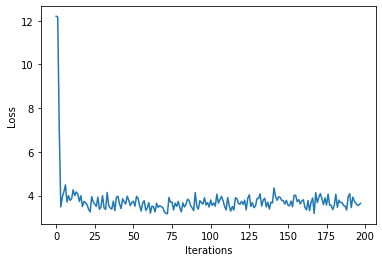

100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


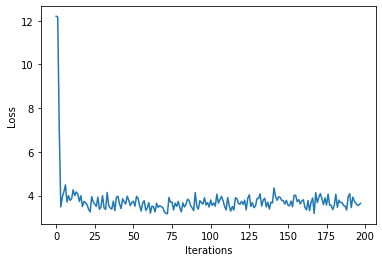

In [20]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# model.trainable_variables

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = compute_loss(y, y_hat)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss
    
##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for iter in tqdm(range(num_training_iterations)):
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch)
    
    history.append(loss.numpy().mean())
    plotter.plot(history)
    
    if iter % 100 == 0:
        model.save_weights(checkpoint_prefix)

model.save_weights(checkpoint_prefix)

In [21]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            51308800  
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 200425)         205435625 
Total params: 261,991,401
Trainable params: 261,991,401
Non-trainable params: 0
_________________________________________________________________


In [22]:
# prediction of a generated song
def generate_text(model, start_string, generation_length=1000):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []
    model.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0) # remove batch dim
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the prediction along with the previous hidden state
        #   as the next inputs to the model
        input_eval = tf.expand_dims([predicted_id], 0)  
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [23]:
generated_text = generate_text(model, 'X', generation_length=1000)

100%|██████████| 1000/1000 [00:07<00:00, 127.28it/s]


In [24]:
print(generated_text)

Xne:l2ef3fAcFF
c2B2F 8:efBFAeTegeea:Co
FeBef
fGr eE| 2
 d2A

2ee

|
g|d:FX623E  adgfAGA
c
,
A AX
2eB

|f acAa2cc d2dTa
|/ABdeB- 
c3ee 3
em3
eg0f!ecE'f8
93efCdfd   8efaB
FG|


eef 3 BAe e|BXTe2f cFG' |

fC2gf vdX'3d2G
e

edbT

dA  e^BD

|egF83:a ee8e Ae c,f3B 
 eBpd:::Xe82b fmceBe
g!:
XfZ2Adm3 T
2fdXe:ed E
Kf:f
2g|i38Ge:d3B|cngf d|
T 2:e:AfKCB3e
Ae
7fcA2
g3f
d
| ||eBPF
 
eAe2 F efB2ecBA

 Xe!Gb:T c82dePf2!p3
|a
d8
d| -FBfAT8ee3Fn
d/dg dgG
|g


dm /2| 8c|edeeF:f3d

 nefff:ffFFf A!2 ee
l3Ac
b2ee2
2e|e:eoGBXlaecdTaA Gedca  2b|e2Go l!> eAdd
7g
2b/!|AA3oeB 283e2eBeC:AXEGGe eZd e32dgeF-XgB
Ge:a23

Xge  dKfa:3fe=
ce
2 FceA 232ag:bff
eBFgf2f8ofr !dFgc HBml
:BeG2a2da2f|:edc
 'eaedTeBfdGBd 2
e:
7
Ff2Xee 2d22 eFEEee72meiFefBE:
cGfBeaX2dF|c 2e:8
FfBcA e
Afl: e7ec e ee
e3 aB  3e!23|ef|d gBd gfdd2
oCe eedgfa8eBede3AdBg Tp2d c:
ZedFmE
A aZe  

dFeEEn e:ddjA4|2egf d
Z|
edEge
XZfiFfG
eie eA mu2Gf
e:cf3d deXeGcadedF
fdCdf
2dB3
B
cee  |f : F c co
'2dddf
3e
e:-3:
lieT
B 2f
AteegEX!3 2fE3T de7XAF|nFcdg  Fg2

In [31]:
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
    # mdl.lab1.play_song(song)
    waveform = mdl.lab1.play_song(song)

    if waveform:
        print("Generated song", i)
        ipythondisplay.display(waveform)

Found 14 songs in text
